# 第四章 非参数滤波

## 1. 对前面章节讨论的线性系统进行直方图滤波

### a). 对3.1的动态系统进行直方图滤波，绘制$t=1,2,...,5$每个时刻的$x,\dot{x}$联合概率分布

根据3.1的分析，可以得到

$$
\begin{align}
A&=\begin{bmatrix}1 &1\\0 &1 \end{bmatrix} \\
B&=\begin{bmatrix}\frac{1}{2} \\1 \end{bmatrix} \\
R&=\begin{bmatrix}\frac{1}{4} &\frac{1}{2}\\\frac{1}{2} &1 \end{bmatrix} + \begin{bmatrix}1 &1\\1 &1 \end{bmatrix}\times 10^{-5}
\end{align}
$$

注：其中协方差矩阵 $R$ 是奇异矩阵不可逆，为计算高斯分布的概率，需要在该矩阵上加小量使其可逆

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

A = np.mat([[1, 1],[0, 1]])
B = np.mat([[0.5], [1.0]])
mu = np.mat([[0],[0]])
R = B*B.T + np.ones(2)*1e-5

为进行直方图滤波，首先需要对状态空间进行离散化，这里将$\begin{bmatrix} x \\ \dot{x} \end{bmatrix} $ 划分在 $-10\sim 10$ 的空间，步长取 $0.25$，时刻$t$的概率分布由下式给定

$$
\begin{align}
p(x_t)=\sum_{x_{min}}^{x_{max}}\sum_{\dot{x}_{min}}^{\dot{x}_{max}}p(x_t|x_{t-1})*p(x_{t-1})
\end{align}
$$

其中状态转移函数$p(x_t|x_{t-1})$与3.1中一致，系统初始概率分布由 $\Sigma_0=\begin{bmatrix}10^{-10} &0\\0 &10^{-10} \end{bmatrix}$ 确定

(40, 40)
figure 0
figure 1
figure 2
figure 3
figure 4
figure 5


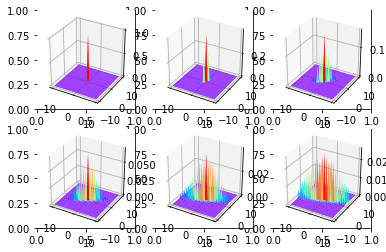

In [2]:
Sigma_0 = np.mat([[1e-10, 0],[0, 1e-10]])

delta = 0.5
X_max = 10
X_dot_max = 10
X_min = -10
X_dot_min = -10

X=np.arange(X_min, X_max, delta)
X_dot=np.arange(X_dot_min, X_dot_max, delta)
X, X_dot=np.meshgrid(X, X_dot)
P=np.ones(X.shape)/((X_max-X_min)/delta*(X_dot_max-X_dot_min)/delta)
#initialize P_0
sum = 0.0
for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            X_0=np.mat([[X[i][j]], [X_dot[i][j]]])
            P[i][j]=math.pow(math.e, -1.0/2.0 * X_0.T * Sigma_0.I * X_0)
            sum+=P[i,j]

P = P/sum
print(X.shape)

fig,ax = plt.subplots(2,3)

#from time 0 to 5
for i in range(6):
    print("figure", i)
    ax = fig.add_subplot(2,3,1+i, projection='3d')
    P_bar=np.zeros(X.shape)

    # calculate probabilitics
    sum = 0.0
    for i in range(P_bar.shape[0]):
        for j in range(P_bar.shape[1]):
            X_t=np.mat([[X[i][j]], [X_dot[i][j]]])
            for i_t_1 in range(P.shape[0]):
                for j_t_1 in range(P.shape[1]):
                    X_t_1=np.mat([[X[i_t_1,j_t_1]], [X_dot[i_t_1,j_t_1]]])
                    P_bar[i][j]+=math.pow(math.e, -1.0/2.0 * (X_t-A*X_t_1).T * R.I * (X_t-A*X_t_1))*P[i_t_1, j_t_1]
            sum+=P_bar[i][j]
    P_bar=P_bar/sum

    ax.plot_surface(X, X_dot, P, rstride=1, cstride=1, cmap='rainbow')
    P = P_bar

plt.show()

### b). 对3.2的观测步骤进行直方图滤波，对比观测更新前和更新后的概率分布

根据3.2 可以得到观测矩阵以及观测概率函数
$$
\begin{align}
C &= \begin{bmatrix} 1 &0 \end{bmatrix} \\
Q &= 10 \\
p(z_t|x_t) &\sim N(Cx_t, Q)
\end{align}
$$
通过测量跟新可以得到新的概率分布如下

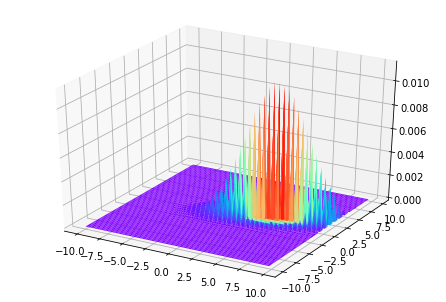

In [3]:
C = np.mat([1, 0])
Q = np.mat([10])
Z = 5
P_z = np.zeros(P.shape)
sum = 0.0
for i in range(P_z.shape[0]):
    for j in range(P_z.shape[1]):
        X_t=np.mat([[X[i][j]], [X_dot[i][j]]])
        P_z[i,j] = math.pow(math.e, -1.0/2.0 * (Z-C*X_t).T * Q.I * (Z-C*X_t))*P[i, j]
        sum+=P_z[i,j]
P_z=P_z/sum

fig=plt.figure()
ax=Axes3D(fig)
ax.plot_surface(X, X_dot, P_z, rstride=1, cstride=1, cmap='rainbow')
plt.show()

## 2. 对习题3.4进行直方图滤波实现

### a). 为直方图滤波建议一个合适的初值估计

初值估计由三维高斯分布给定，分布的均值和方差如下

$$
\begin{align}
\mu_0 &= \begin{bmatrix}0 \\0 \\0 \end{bmatrix} \\
\Sigma_0 &= \begin{bmatrix} 0.01 &0 &0 \\0 &0.01 &0 \\0 &0 &10000 \end{bmatrix}
\end{align}
$$

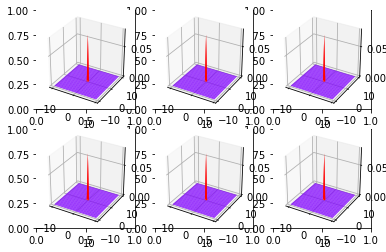

In [19]:
delta = 0.5
X_max = 10
Y_max = 10
X_min = -10
Y_min = -10
Theta_max = 2 * math.pi
Theta_min = 0

X = np.arange(X_min, X_max, delta)
Y = np.arange(Y_min, Y_max, delta)
Theta = np.arange(Theta_min, Theta_max, delta)
P_0=np.zeros((X.size,Y.size,Theta.size))

X_mesh, Y_mesh = np.meshgrid(X,Y)

mu = np.mat([[0.0], [0.0],[0.0]])
Sigma_0 = np.mat([[0.01, 0,0], [0,0.01,0], [0,0,10000]])

sum = 0
for i in range(X.size):
    for j in range(Y.size):
        for k in range(Theta.size):
            x = np.mat([[X[i]],[Y[j]],[Theta[k]]])
            P_0[i,j,k] = math.pow(math.e, -1.0/2.0*(x - mu).T*Sigma_0.I*(x-mu))
            sum += P_0[i,j,k]
P_0 = P_0/sum

fig,ax=plt.subplots(2,3)
for i in range(6):
    ax = fig.add_subplot(2,3,1+i, projection='3d')
    ax.plot_surface(X_mesh, Y_mesh, P_0[:,:,i], rstride=1, cstride=1, cmap='rainbow')
plt.show()

### b). 实现直方图滤波预测步骤并与EKF的结果进行对比

首先需要获得状态转移函数的概率分布，题目中假设机器人可以不受噪声影响的移动，那么有

$$
p(x_t|x_{t-1}) =
 \begin{cases} 
1 &&x_t = g(x_{t-1}, u_t) \\
0 &&x_t \not= g(x_{t-1}, u_t)
\end{cases} 
$$

其中$g(x_{t-1}, u_t)$ 为预测方程
$$
g(x_{t-1}, u_t)= \begin{bmatrix} x_{t-1} + u_t \cos(\theta_{t-1}) \\ y_{t-1} + u_t \sin(\theta_{t-1}) \\ \theta_{t-1} \end{bmatrix}
$$

In [ ]:
P_1 = np.zeros(P_0.shape)
delta_v = np.mat([[delta],[delta],[delta]])

sum = 0
for i in range(X.size):
    for j in range(Y.size):
        for k in range(Theta.size):
            x_t = np.mat([[X[i]],[Y[j]],[Theta[k]]])
            for i_t_1 in range(X.size):
                for j_t_1 in range(Y.size):
                    for k_t_1 in range(Theta.size):
                        x_t_1 = np.mat([[X[i_t_1]],[Y[j_t_1]],[Theta[k_t_1]]])
                        non_linear = np.mat([[math.cos(Theta[k_t_1])],[math.sin(Theta[k_t_1])],[0]])
                        x_delta = x_t - x_t_1 - non_linear
                        if x_delta[0] < delta_v[0] and x_delta[1] < delta_v[1] and x_delta[2] < delta_v[2]:
                            P_1[i,j,k] += 1 * P_0[i_t_1, j_t_1, k_t_1]
                        else:
                            P_1[i,j,k] += 0
                        sum += P_1[i,j,k]
P_1 /=sum

fig,ax=plt.subplots(2,3)
for i in range(6):
    ax = fig.add_subplot(2,3,1+i, projection='3d')
    ax.plot_surface(X_mesh, Y_mesh, P_1[:,:,i], rstride=1, cstride=1, cmap='rainbow')
plt.show()

### c). 将测量归并入估计，将结果与EKF进行比较